In [43]:
import tensorflow as tf
import numpy as np
import mdn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

Source: https://www.katnoria.com/mdn/ and https://github.com/cpmpercussion/keras-mdn-layer/blob/master/notebooks/MDN-2D-spiral-prediction.ipynb

Generate train and test data (10 dimensional input and otput

In [151]:
def gen_data(n=1000, cols=2):
    # sample uniformly over the interval (0,1)
    X = np.random.uniform(0., 1., (n,cols)).astype(np.float32)    
    # Add 2 to have strictly positive Y
    y = 2 + (X + 0.3 * np.sin(2 * np.pi * X) + 0.2 * np.tan(np.pi / 2 * X) + np.random.uniform(-0.1, 0.1, size=(n,cols)).astype(np.float32))
    return X,y

X,y = gen_data(n=20000, cols=10)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.10, random_state=42)

display(pd.DataFrame(y_test).describe())

,0,1,2,3,4,5,6,7,8,9
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.615034,3.267617,4.053592,9.421212,3.954029,4.150867,3.937071,3.510375,4.306158,3.270168
std,12.074900,4.379744,30.411219,190.439178,18.233643,24.917324,14.574010,6.602884,42.716599,3.143604
min,1.931069,1.919399,1.932806,1.926581,1.955224,1.925359,1.930354,1.912630,1.944402,1.924374
25%,2.606955,2.601793,2.621750,2.617450,2.620316,2.615520,2.615036,2.606159,2.603743,2.615273
50%,2.718506,2.710202,2.723087,2.724280,2.724586,2.722993,2.726348,2.719437,2.713055,2.724423
75%,2.943890,2.906171,2.991657,2.943192,2.974401,2.973311,2.943957,2.987256,2.909145,2.971518
max,498.316986,108.085106,1354.224121,7471.788574,759.466125,907.086975,554.168762,237.240692,1901.668213,86.301041


Define our neural network with 1 hidden layer of 256 nodes and 20 mixture density models

In [152]:
# Number of cols
l = 10
# Number of gaussians to represent the multimodal distribution (number of mixture density models)
k = 20

# Network
input = tf.keras.Input(shape=(l,))

layer = tf.keras.layers.Dense(256, activation='sigmoid', name='baselayer')(input)
#layer_2 = tf.keras.layers.Dense(64, activation='sigmoid', name='baselayer2')(layer)
# Connect the mdn layer to the output of our neural network
mdn_layer = mdn.MDN(l,k, name='mdn')(layer)

Build the model and display the summary

In [153]:
model = tf.keras.models.Model(input, [mdn_layer])
model.compile(loss=mdn.get_mixture_loss_func(l,k), optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "functional_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
baselayer (Dense)            (None, 256)               2816      
_________________________________________________________________
mdn (MDN)                    (None, 420)               107940    
Total params: 110,756
Trainable params: 110,756
Non-trainable params: 0
_________________________________________________________________


Fit our model on the data with 300 iterations

In [155]:
fit = model.fit(x=X_train, y=y_train, batch_size=128, epochs=1000, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Epoch 1/1000
127/127 [==============================] - 0s 3ms/step - loss: 68.3724 - val_loss: 23.1825
Epoch 2/1000
127/127 [==============================] - 0s 3ms/step - loss: 66.1413 - val_loss: 22.6586
Epoch 3/1000
127/127 [==============================] - 0s 3ms/step - loss: 64.1613 - val_loss: 22.0307
Epoch 4/1000
127/127 [==============================] - 0s 3ms/step - loss: 62.1398 - val_loss: 21.5690
Epoch 5/1000
127/127 [==============================] - 0s 3ms/step - loss: 60.2215 - val_loss: 20.9884
Epoch 6/1000
127/127 [==============================] - 0s 3ms/step - loss: 58.4726 - val_loss: 20.5177
Epoch 7/1000
127/127 [==============================] - 0s 3ms/step - loss: 56.7565 - val_loss: 20.0580
Epoch 8/1000
127/127 [==============================] - 0s 3ms/step - loss: 54.9648 - val_loss: 19.5187
Epoch 9/1000
127/127 [==============================] - 0s 3ms/step - loss: 53.3679 - val_loss: 19.1614
Epoch 10/1000
127/127 [==============================] - 0s 4ms/

Obtained a loss of -1.5942. The 1D example from medium had a loss of around -1.

In [ ]:
Plot the loss over the number of iterations

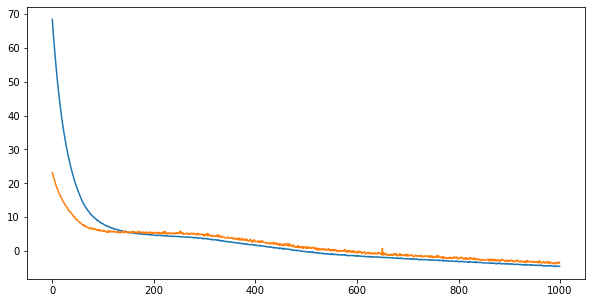

In [156]:
plt.figure(figsize=(10, 5))
#plt.ylim([-5, 5])
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.show()

Get the predictions from our model by sampling the posterior distribution. Each mixture model produces a mean and sigma in each dimension for each test observation rather than a point estimate.

In [166]:
# Returns the predictions of the parameters of the distributions and weights
%time
preds = model.predict(X_test)
samples_list = []
# Obtain 10 samples per prediction
for i in range(10):
    samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, l, k, temp=1.0, sigma_temp=1.0))

# Average the samples for our predicitons
y_samples = np.mean(np.array(samples_list),axis=0)
y_samples = y_samples.reshape(2000,10)


CPU times: user 6 µs, sys: 8 µs, total: 14 µs
Wall time: 526 µs


Calcuate the entropy between each predicted distribution and test distribution

In [182]:
from scipy.stats import entropy
ent = []
# Turn all negative preds to 0
y_samples = np.clip(y_samples,0, a_max=None)
for i in range(len(y_test)):
     e = entropy(y_samples[i], y_test[i])
     ent.append(e if e != np.inf else 1000)   
display(pd.DataFrame(ent).describe())

,0
count,2000.000000
mean,0.084935
std,0.273626
min,0.000133
25%,0.005137
50%,0.014521
75%,0.048432
max,4.722300


In [164]:
def gen_data_sin(n=1000, cols=2):
    # sample uniformly over the interval (0,1)
    X = np.random.uniform(0., 1., (n,cols)).astype(np.float32)    
    # Add 2 to have strictly positive Y
    y = 2 + (X + 0.3 * np.sin(2 * np.pi * X) + np.random.uniform(-0.1, 0.1, size=(n,cols)).astype(np.float32))
    return X,y

X_sin,y_sin = gen_data_sin(n=20000, cols=10)

X_train_sin, X_test_sin, y_train_sin, y_test_sin = train_test_split(X_sin,y_sin, test_size=0.10, random_state=42)

display(pd.DataFrame(y_test_sin).describe())

fit = model.fit(x=X_train_sin, y=y_train_sin, batch_size=128, epochs=100, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

# Returns the predictions of the parameters of the distributions and weights
preds_sin = model.predict(X_test_sin)
samples_list_sin = []
# Obtain 10 samples per preidciton
for i in range(10):
    samples_list_sin.append(np.apply_along_axis(mdn.sample_from_output, 1, preds_sin, l, k, temp=1.0, sigma_temp=1.0))

# Average the samples for our predicitons
y_samples_sin = np.mean(np.array(samples_list),axis=0)
y_samples_sin = y_samples_sin.reshape(2000,10)



,0,1,2,3,4,5,6,7,8,9
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.499647,2.496840,2.503687,2.503855,2.504160,2.492263,2.488502,2.493412,2.501250,2.499714
std,0.189138,0.191169,0.192166,0.194781,0.187986,0.189792,0.196444,0.200862,0.192521,0.192397
min,1.910273,1.922096,1.915850,1.910727,1.955644,1.922488,1.919669,1.922958,1.916764,1.923399
25%,2.400764,2.402421,2.408334,2.400783,2.402356,2.395525,2.390674,2.394832,2.402554,2.406376
50%,2.497742,2.496651,2.500411,2.501384,2.498127,2.498449,2.493083,2.495152,2.500687,2.499824
75%,2.594481,2.598622,2.598980,2.605112,2.596828,2.592149,2.581927,2.593751,2.589715,2.590080
max,3.096285,3.061361,3.078503,3.079951,3.077315,3.076648,3.097432,3.077092,3.070284,3.093505


Epoch 1/100
127/127 [==============================] - 0s 4ms/step - loss: -12.7499 - val_loss: -12.9041
Epoch 2/100
127/127 [==============================] - 0s 4ms/step - loss: -12.7504 - val_loss: -12.6577
Epoch 3/100
127/127 [==============================] - 0s 4ms/step - loss: -12.6996 - val_loss: -12.7451
Epoch 4/100
127/127 [==============================] - 1s 4ms/step - loss: -12.8146 - val_loss: -12.6038
Epoch 5/100
127/127 [==============================] - 1s 4ms/step - loss: -12.7556 - val_loss: -12.5374
Epoch 6/100
127/127 [==============================] - 0s 4ms/step - loss: -12.7633 - val_loss: -12.8764
Epoch 7/100
127/127 [==============================] - 0s 4ms/step - loss: -12.8177 - val_loss: -12.7748
Epoch 8/100
127/127 [==============================] - 0s 4ms/step - loss: -12.8086 - val_loss: -12.7213
Epoch 9/100
127/127 [==============================] - 0s 4ms/step - loss: -12.7989 - val_loss: -12.9274
Epoch 10/100
127/127 [==============================] -

In [181]:
from scipy.stats import entropy
ent_sin = []
# Turn all negative preds to 0
y_samples_sin = np.clip(y_samples_sin,0, a_max=None)
for i in range(len(y_test)):
     e = entropy(y_samples_sin[i], y_test_sin[i])
     ent_sin.append(e if e != np.inf else 1000)   
display(pd.DataFrame(ent_sin).describe())

,0
count,2000.000000
mean,0.117683
std,0.291106
min,0.000796
25%,0.006736
50%,0.013835
75%,0.068446
max,2.079490


In [175]:
print([idx for idx,e in enumerate(ent_sin) if e == 1000])
print(y_samples_sin[25])
print(y_test_sin[25])

[7, 13, 25, 38, 49, 62, 66, 119, 121, 127, 140, 171, 179, 180, 199, 227, 253, 268, 291, 321, 326, 349, 350, 376, 381, 386, 409, 426, 433, 440, 448, 454, 461, 472, 504, 512, 528, 580, 629, 636, 645, 652, 681, 712, 719, 729, 798, 813, 842, 850, 873, 878, 902, 915, 916, 939, 948, 951, 957, 964, 969, 981, 1011, 1017, 1025, 1037, 1048, 1052, 1055, 1080, 1086, 1112, 1169, 1193, 1199, 1249, 1257, 1277, 1280, 1281, 1287, 1291, 1301, 1302, 1331, 1356, 1374, 1386, 1391, 1394, 1398, 1424, 1425, 1442, 1455, 1456, 1474, 1495, 1527, 1536, 1547, 1549, 1555, 1593, 1598, 1603, 1621, 1631, 1644, 1651, 1659, 1689, 1693, 1694, 1707, 1717, 1734, 1737, 1745, 1759, 1773, 1780, 1797, 1802, 1855, 1886, 1891, 1921, 1929, 1956, 1995]
[ 3.26747821  6.14933476  2.6585072   3.09475314  2.45635291 -7.58402554
  2.65225544  3.26880631  8.37458965  2.3776149 ]
[2.3558784 2.478197  2.1245105 2.6911554 2.4723806 2.5258257 2.4309087
 2.4078817 2.550756  2.380342 ]
